In [1]:
import os
import numpy as np
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
from utils import compute_rdc, plot_sq

In [2]:
sz_smri_data_path = "/Users/xli77/Dropbox (GaTech)/MISA/MISA-data/sMRI-fMRI-DTI/mancovaOuts_allHCSZ_combinedRelatives_wX_preregSite_C30_SMRI_GICAinit.mat"
sz_smri_data = sio.loadmat(sz_smri_data_path)['NMODELHCSZ0ns']
sz_smri_data_array = sz_smri_data[0][0][0]
age = sz_smri_data_array[:,0]
sex = sz_smri_data_array[:,1]
diagnosis = sz_smri_data_array[:,2]
id = sio.loadmat("/Users/xli77/Dropbox (GaTech)/MISA/MISA-data/sMRI-fMRI-DTI/SZID.mat")['ID'][0] - 1

In [3]:
datapath="/Users/xli77/Dropbox (GaTech)/MISA/results/SIVA/fixedSubspace/um2mm/seed7_snr1000"
subspace_struct_list=['234111','2222211','333111','441111','12x1']
num_subspace_struct=len(subspace_struct_list)

Y = np.zeros((num_subspace_struct,3,2,12,999)) # S1-4, UA/MSIVA/GICA, M1-2, voxel, source
W = np.zeros((num_subspace_struct,3,2,12,44318)) # S1-4, UA/MSIVA/GICA, M1-2, voxel, source

num_iter=21
corr = np.zeros((num_subspace_struct,9,12,12))

for i,ss in enumerate(subspace_struct_list):

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging_sz_Y.mat"))
    Y1=np.squeeze(data['Y1'])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging_sz_Y.mat"))
    Y2=np.squeeze(data['Y2'])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","mm_neuroimaging_sz_Y.mat"))
    Y3=np.squeeze(data['Y3'])

    Y[i,0,0]=Y1[0][:,id]
    Y[i,0,1]=Y1[1][:,id]
    Y[i,1,0]=Y2[0][:,id]
    Y[i,1,1]=Y2[1][:,id]
    Y[i,2,0]=Y3[0][:,id]
    Y[i,2,1]=Y3[1][:,id]

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging_sz_W.mat"))
    W1=np.squeeze(data['W1'])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging_sz_W.mat"))
    W2=np.squeeze(data['W2'])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","mm_neuroimaging_sz_W.mat"))
    W3=np.squeeze(data['W3'])

    W[i,0,0]=W1[0]
    W[i,0,1]=W1[1]
    W[i,1,0]=W2[0]
    W[i,1,1]=W2[1]
    W[i,2,0]=W3[0]
    W[i,2,1]=W3[1]

    corr[i,0] = compute_rdc(Y1[0],Y1[0])
    corr[i,1] = compute_rdc(Y1[1],Y1[1])
    corr[i,2] = compute_rdc(Y1[0],Y1[1])

    corr[i,3] = compute_rdc(Y2[0],Y2[0])
    corr[i,4] = compute_rdc(Y2[1],Y2[1])
    corr[i,5] = compute_rdc(Y2[0],Y2[1])

    corr[i,6] = compute_rdc(Y3[0],Y3[0])
    corr[i,7] = compute_rdc(Y3[1],Y3[1])
    corr[i,8] = compute_rdc(Y3[0],Y3[1])

In [4]:
val = 1
num_source = 12

# S1
num_unique_source = 3
s1 = np.zeros((num_source, num_source))
s1[:2,:2] = val
s1[2:5,2:5] = val*2
s1[5:9,5:9] = val*3

# S2
num_unique_source = 2
s2 = np.zeros((num_source, num_source))
s2[:2,:2] = val
s2[2:4,2:4] = val*2
s2[4:6,4:6] = val*3
s2[6:8,6:8] = val*4
s2[8:10,8:10] = val*5

# S3
num_unique_source = 3
s3 = np.zeros((num_source, num_source))
s3[:3,:3] = val
s3[3:6,3:6] = val*2
s3[6:9,6:9] = val*3

# S4
num_unique_source = 4
s4 = np.zeros((num_source, num_source))
s4[:4,:4] = val
s4[4:8,4:8] = val*2

# S5
num_unique_source = 4
s5 = np.zeros((num_source, num_source))
for i in range(12):
    s5[i,i] = val*(i+1)

s_list = [s1, s2, s3, s4, s5]

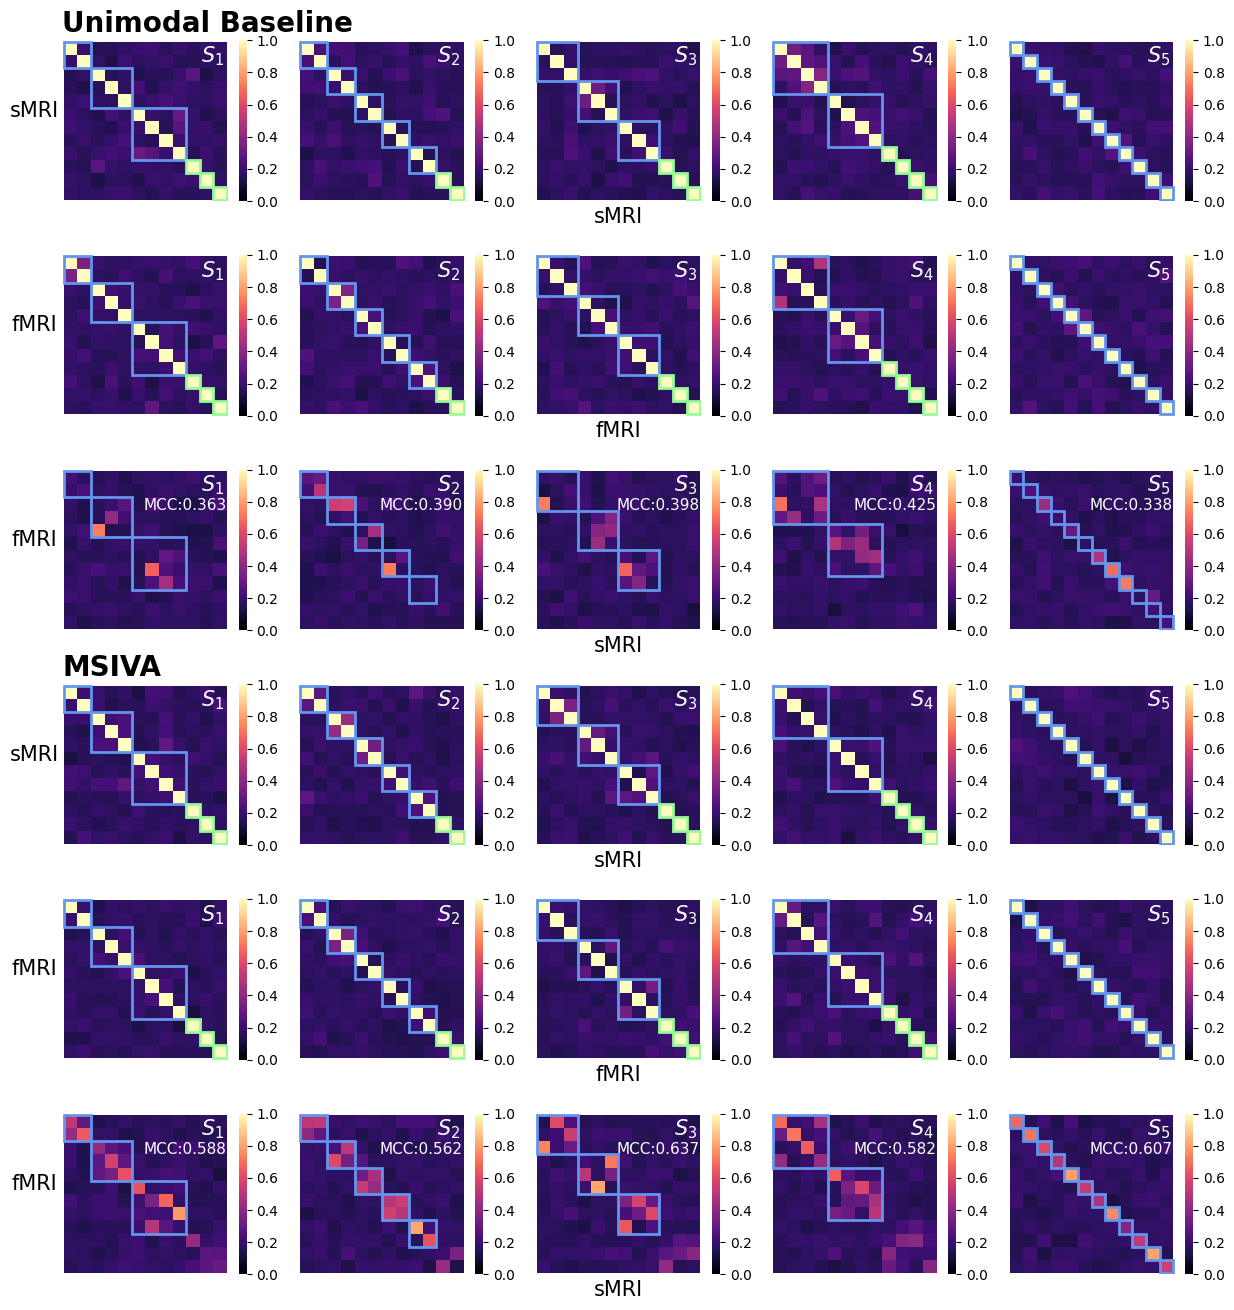

In [5]:
analysis_list = ["Unimodal Baseline"]*3+["MSIVA"]*3
modality_list = ["sMRI", "fMRI"]
subspace_dict = {"S1": [2, 3, 4], "S2": [2, 2, 2, 2, 2], "S3": [3, 3, 3], "S4": [4, 4], "S5": [1]*12}

fig, axes = plt.subplots(6,num_subspace_struct,figsize=(2.5*num_subspace_struct,2.2*6))

for i in range(num_subspace_struct):
    ss = subspace_dict[f"S{i+1}"]
    for j in range(6):
        ax = axes[j,i]
        if j == 2 or j == 5:
            abscorr = np.abs(corr[i,j])
            abscorr_subspace_list = []
            for k, d in enumerate(ss):
              ind_start = sum(ss[:k])
              abscorr_subspace = abscorr[ind_start:ind_start+d,ind_start:ind_start+d]
              # abscorr_subspace_sorted = abscorr_subspace[linear_sum_assignment(-1 * abscorr_subspace)]
              # abscorr_subspace_list.append(np.mean(abscorr_subspace_sorted))
              maxrow = np.max(abscorr_subspace, axis=1)
              maxcol = np.max(abscorr_subspace, axis=0)
              mean_corr = np.sum((maxrow, maxcol))/(2*d)
              abscorr_subspace_list.append(mean_corr)
            # for k in range(1, len(np.unique(s_list[i]))):
            #   abscorr_subspace_list.append(np.mean(abscorr[s_list[i]==k]))
            mcc = np.mean(abscorr_subspace_list)
            sns.heatmap(np.abs(corr[i,j]),cmap="magma",vmin=0,vmax=1,ax=ax)
            ax.text(10.9, 1.1, f"$S_{i+1}$", fontsize=15, color="white", ha="center", va="center")
            ax.text(8.9, 2.6, f"MCC:{mcc:.3f}", fontsize=11, color="white", ha="center", va="center")
            if i == 2:
              ax.set_xlabel("sMRI",fontsize=15)
            if i == 0:
              ax.set_ylabel("fMRI",fontsize=15,rotation=0,labelpad=20)
            plot_sq(ax, i, crossmodal=True)
            ax.set_xlim(-0.1, 12.1)
            ax.set_ylim(12.1, -0.1)
        else:
            mcc = np.mean(np.diag(np.abs(corr[i,j])))
            sns.heatmap(np.abs(corr[i,j]),cmap="magma",vmin=0,vmax=1,ax=ax)
            ax.text(10.9, 1.1, f"$S_{i+1}$", fontsize=15, color="white", ha="center", va="center")
            # ax.text(8.95, 2.6, f"MCC:{mcc:.3f}", fontsize=11, color="white", ha="center", va="center")
            if i == 2:
               ax.set_xlabel(f"{modality_list[j%3]}",fontsize=15)
            if i == 0:
              ax.set_ylabel(f"{modality_list[j%3]}",fontsize=15,rotation=0,labelpad=20)
            plot_sq(ax, i)
            ax.set_xlim(-0.1, 12.1)
            ax.set_ylim(12.1, -0.1)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0 and j == 0:
            ax.set_title(analysis_list[j],loc="left",fontsize=20,fontweight="bold")
        if i == 0 and j == 3:
            ax.set_title(analysis_list[j],loc="left",fontsize=20,fontweight="bold")

plt.tight_layout()
plt.savefig("neuroimaging_rdc_sz.pdf")